In [1]:
# for data
import pybaseball as bb 

# to prepare data for modeling 
import pandas as pd 

# import machine learning models 
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import log_loss, accuracy_score 

# import optuna 
import optuna 

# for exploratory analysis
import seaborn as sns 
import matplotlib.pyplot as plt

In [2]:
# downloading regular season worth of pitching data
df = bb.statcast(start_dt='2023-04-01', end_dt='2023-10-31')

#df = pd.read_csv("data.csv")

# drop any pitch types that are null 
df = df.dropna(subset=['pitch_type'])

# reset index (for model preparation)
df = df.reset_index(drop=True)

# print the shape of the data 
df.shape

This is a large query, it may take a moment to complete


  7%|▋         | 16/214 [00:03<00:35,  5.62it/s]

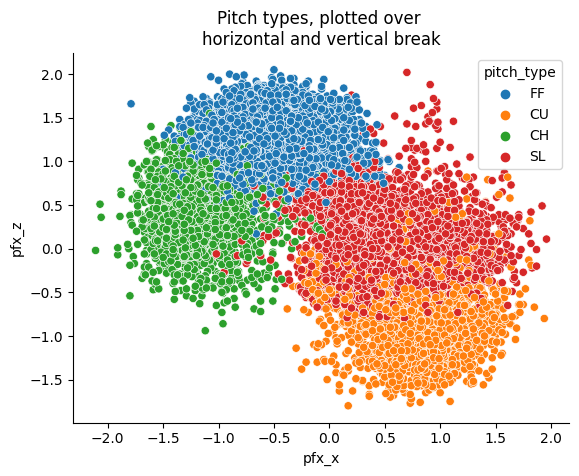

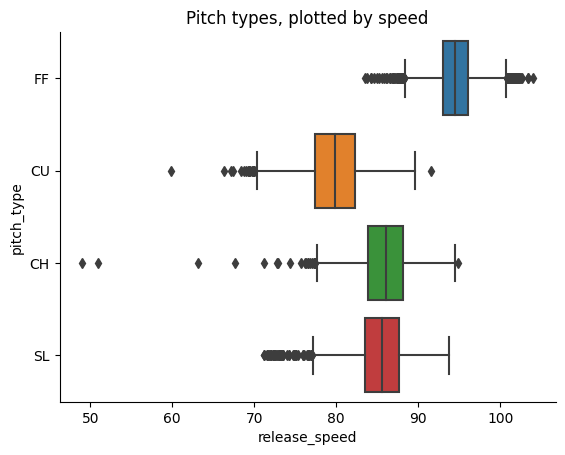

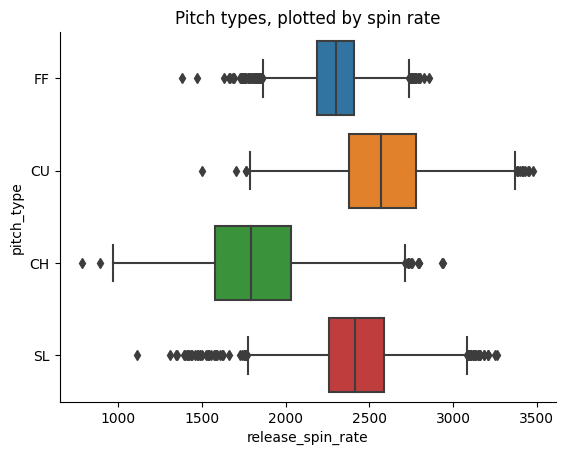

In [ ]:
# subset a smaller amount of data 
# 20k rows, 4 pitch types and right-handed pitchers
df_plt = (df
          .loc[(df['pitch_type']
                .isin(['FF','SL','CU', 'CH'])) & 
               (df['p_throws']=='R')]
          .sample(20000))


# plot the "break" of the pitch, 
# break is the difference between ideal physics and 
# earth physics (aka gravity + air resistance)
sns.scatterplot(data=df_plt, 
                x='pfx_x', 
                y='pfx_z', 
                hue='pitch_type')
sns.despine()
plt.title('Pitch types, plotted over \nhorizontal and vertical break')
plt.show()

# plot the speed of a pitch
sns.boxplot(data=df_plt, 
            x='release_speed', 
            y='pitch_type', 
            orient='h')
sns.despine()
plt.title('Pitch types, plotted by speed')
plt.show()

# plot the spin rate of a pitch 
sns.boxplot(data=df_plt, 
            x='release_spin_rate', 
            y='pitch_type', 
            orient='h')
sns.despine()
plt.title('Pitch types, plotted by spin rate')
plt.show()

We can see from our exploratory data analysis that break, speed, and spin rate all can differentiate pitch types. Let's use these features for our model in order to classify pitch types.

In [ ]:
# define lefty pitchers and righty pitchers
df['is_lefty'] = 0
df.loc[df['p_throws'] == 'L', 'is_lefty'] = 1

# define the features (break, spin, speed) and the target variable (pitch types)
id_feats = ['player_name', 'pitcher', 'pitch_type']
feats = ['is_lefty', 'release_speed', 'release_spin_rate', 'pfx_x', 'pfx_z']
target = 'pitch_type_code'

# Create pitch type code as categorical variable
df['pitch_type_code'] = df['pitch_type'].astype('category').cat.codes

# Subset the data (excluding 'KN' pitch type)
subset = df.loc[df['pitch_type']!=('KN', 'SV'), id_feats+feats+[target]]

# Drop rows with null values
subset = subset.dropna()

# split the data so 50k pitches are in the test set and 100k pitches are in the train set
test = subset.sample(50000)
train = subset.loc[~subset.index.isin(test.index.values)].sample(100000)


In [ ]:
# in order to know what pitch types are what, let's create a mapping system 
# so we can change the coded pitches back to the pitch type names 
map_pitch_types = (subset
                   .loc[:, ['pitch_type', 'pitch_type_code']]
                   .drop_duplicates()
                   .set_index('pitch_type_code')
                   .to_dict()['pitch_type'])

# list all the unique pitch type names 
pitch_types = subset['pitch_type'].unique()

# print the pitch type names alongside the pitch codes 
subset.loc[:, ['pitch_type', 'pitch_type_code']].drop_duplicates().sort_values('pitch_type_code')

,pitch_type,pitch_type_code
35,CH,0
32106,CS,1
37,CU,2
13496,EP,3
13498,FA,4
6,FC,5
1,FF,6
28256,FO,7
1042,FS,8
1027,KC,9


In [ ]:
# train a logistic regression 
logr = LogisticRegression()

# fit the model 
logr.fit(train.loc[:, feats], train[target])

# predict probabilities of each pitch type 
_df = (pd
       .DataFrame(logr.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types))

# append the data back to the test dataset 
test = pd.concat([test,_df], axis=1)

# use the highest probability pitch type as the estimated pitch type 
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

C:\Users\NITISH KUMAR\AppData\Roaming\Python\Python310\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [ ]:
# check data quality 
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,CH,...,FS,KC,KN,PO,SC,SI,SL,ST,SV,pitch_type_pred
382899,"Woo, Bryan",693433,FF,0,93.5,2040,-0.29,0.93,6,0.181285,...,0.021472,0.007430,9.876461e-91,2.136836e-91,2.260499e-76,0.270659,0.012585,0.005041,0.001733,FF
628259,"Gomber, Austin",596295,SI,1,90.9,2215,0.93,1.66,13,0.089665,...,0.017745,0.020389,5.275590e-98,1.023762e-98,2.093124e-82,0.198706,0.069908,0.025408,0.003037,FF
534023,"Elder, Bryce",693821,SL,0,83.0,2308,-0.02,-0.32,14,0.020215,...,0.008056,0.038654,6.224954e-102,1.155977e-102,1.136095e-85,0.069565,0.289684,0.097947,0.003700,SL
118532,"Gallegos, Giovanny",606149,FF,0,94.6,2407,-0.79,1.17,6,0.057111,...,0.012916,0.024821,2.846896e-106,4.835262e-107,2.557383e-89,0.157900,0.122147,0.040336,0.002760,FF
541974,"Ortiz, Luis L.",682847,SI,0,95.7,2206,-1.11,0.43,13,0.131768,...,0.018683,0.011417,8.755620e-98,1.691751e-98,2.978386e-82,0.245567,0.028192,0.010363,0.002004,FF
117959,"Loáisiga, Jonathan",642528,CU,0,85.7,2714,1.21,0.23,2,0.001065,...,0.000789,0.021191,6.099538e-120,8.638864e-121,8.223235e-101,0.006835,0.474254,0.129686,0.000934,SL
328248,"Waldichuk, Ken",686610,FF,1,94.2,2281,0.9,1.31,6,0.092205,...,0.016723,0.017977,6.736944e-101,1.243446e-101,7.787163e-85,0.204981,0.061725,0.021756,0.002573,FF
543408,"Verlander, Justin",434378,CU,0,79.5,2582,0.37,-0.63,2,0.000846,...,0.000726,0.021245,2.947993e-114,4.611440e-115,4.679746e-96,0.005333,0.463686,0.134187,0.001023,SL
113699,"Okert, Steven",595345,FF,1,93.5,2459,0.54,1.37,6,0.038376,...,0.010326,0.029601,1.712935e-108,2.818743e-109,3.593518e-91,0.120075,0.183991,0.058909,0.002849,FF
548625,"Bickford, Phil",641360,FF,0,93.8,2214,-0.64,1.43,6,0.112220,...,0.018328,0.014664,4.684630e-98,9.040883e-99,1.820513e-82,0.226327,0.041670,0.015254,0.002394,FF


In [ ]:
# produce accuracy and log loss metrics to evaluate model performance 
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.44858, 10.19784792378314)

This logistic regression classifier produced about 44% accuracy, with a log loss of 10.19. We know from the EDA that some of these features are not linear (i.e. break) so it is possible that a linear model (like logistic regression) would have difficulties handling the nonlinear features.

Let's try a nonlinear model, random forest.

In [ ]:
# drop old preds 
test = test.drop(pitch_types, axis=1)

In [ ]:
rf = RandomForestClassifier()
rf.fit(train.loc[:, feats], train[target])
_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types))
test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [ ]:
test.sample(10)

,player_name,pitcher,pitch_type,is_lefty,release_speed,release_spin_rate,pfx_x,pfx_z,pitch_type_code,pitch_type_pred,...,FO,FS,KC,KN,PO,SC,SI,SL,ST,SV
243349,"Nola, Aaron",605400,FF,0,94.4,2529,-1.17,1.38,6,FF,...,0.0,0.0,0.0,0.0,0.0,0.0,0.03,0.00,0.00,0.0
138454,"Adon, Joan",672851,SI,0,93.5,2168,-1.03,0.8,13,SI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.83,0.00,0.00,0.0
528717,"Sears, JP",676664,ST,1,81.5,2385,-1.12,0.07,15,ST,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.14,0.62,0.0
181913,"Montero, Rafael",606160,FF,0,95.5,2307,-0.8,1.12,6,FF,...,0.0,0.0,0.0,0.0,0.0,0.0,0.04,0.00,0.00,0.0
352068,"Nola, Aaron",605400,SI,0,92.9,2233,-1.57,0.78,13,SI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.99,0.00,0.00,0.0
401000,"Mikolas, Miles",571945,SI,0,93.9,2328,-1.12,0.86,13,SI,...,0.0,0.0,0.0,0.0,0.0,0.0,0.94,0.00,0.00,0.0
328583,"Festa, Matt",670036,FF,0,91.1,2367,0.22,0.77,6,FC,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.10,0.00,0.0
692508,"Lodolo, Nick",666157,FF,1,93.0,2406,1.52,1.11,6,FF,...,0.0,0.0,0.0,0.0,0.0,0.0,0.10,0.00,0.00,0.0
209773,"Peralta, Freddy",642547,FF,0,94.5,2430,-0.5,1.06,6,FF,...,0.0,0.0,0.0,0.0,0.0,0.0,0.01,0.00,0.00,0.0
716212,"Springs, Jeffrey",605488,CH,1,81.0,1451,1.14,0.51,0,CH,...,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0


In [ ]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.81548, 34.07546024357786)

The random forest model clearly is an improvement in accuracy over the linear model. Although the loss is greater (aka worse), the accuracy is much better. The loss may be poor because the classification is much stronger for perhaps a wrong pitch type (think: someone's slider being classified as a curveball, like I mentioned in the intro.)

Let's use $optuna$ to try and improve our accuracy even further by "smart" tuning our model.

In [ ]:
# drop old preds 
test = test.drop(pitch_types, axis=1)

In [ ]:
def tune(trial):
  n_estimators=trial.suggest_int('n_estimators', 10, 500)
  max_features=trial.suggest_categorical('max_features', ["sqrt", "log2"])
  model = RandomForestClassifier(n_estimators=n_estimators, max_features=max_features)
  model.fit(train.loc[:, feats], train[target])
  _df = (pd
        .DataFrame(model.predict_proba(test.loc[:, feats]), 
                    index=test.index)
        .rename(columns=map_pitch_types))
  _df['pitch_type_pred'] = _df.loc[:, pitch_types].idxmax(axis=1)
  acc = accuracy_score(test['pitch_type'], _df['pitch_type_pred'])
  return acc

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(tune, n_trials=3)

[I 2024-04-25 17:43:32,435] A new study created in memory with name: no-name-d9747bf6-479b-4345-aca6-df23bda55675
[I 2024-04-25 17:44:35,050] Trial 0 finished with value: 0.81702 and parameters: {'n_estimators': 264, 'max_features': 'log2'}. Best is trial 0 with value: 0.81702.
[I 2024-04-25 17:45:14,242] Trial 1 finished with value: 0.81556 and parameters: {'n_estimators': 174, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.81702.
[I 2024-04-25 17:47:04,707] Trial 2 finished with value: 0.8163 and parameters: {'n_estimators': 471, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.81702.


In [ ]:
study.best_params

{'n_estimators': 264, 'max_features': 'log2'}

In [ ]:
rf = RandomForestClassifier(n_estimators=study.best_params['n_estimators'], 
                            max_features=study.best_params['max_features'])
rf.fit(train.loc[:, feats], train[target])
_df = (pd
       .DataFrame(rf.predict_proba(test.loc[:, feats]), 
                  index=test.index)
       .rename(columns=map_pitch_types))
test = pd.concat([test,_df], axis=1)
test['pitch_type_pred'] = test.loc[:, pitch_types].idxmax(axis=1)

In [ ]:
acc = accuracy_score(test['pitch_type'], test.loc[:, 'pitch_type_pred'])
loss = log_loss(test['pitch_type'], test.loc[:, pitch_types])
acc, loss

(0.81696, 33.56936022792003)